In [26]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [27]:
class RedeNeural:
    def __init__(self, X, y, lr=0.1, epocas=10000, n_ocultos=4):
        self.X = X
        self.y = y
        self.lr = lr
        self.epocas = epocas

        #salvando o historico para os graficos
        self.historico_erro = []
        self.historico_pesos = []

        np.random.seed(1)
        n_entradas = X.shape[1]
        n_saidas = y.shape[1]

        # inicializando como em poo
        self.pesosEntradaOculta = 2 * np.random.random((n_entradas, n_ocultos)) - 1
        self.pesosOcultaSaida = 2 * np.random.random((n_ocultos, n_saidas)) - 1
        self.biasEntrada = 2 * np.random.random((1, n_ocultos)) - 1
        self.biasSaida = 2 * np.random.random((1, n_saidas)) - 1

    def sigmoide(self, x):
        return 1 / (1 + np.exp(-x))

    def derivadaSigmoide(self, x):
        return x * (1 - x)

    def forward(self, X_input, pEO, bE, pOS, bS):
        #fazendo o somatorio e a sigmoide com esse somatorio
        s1 = np.dot(X_input, pEO) + bE
        a1 = self.sigmoide(s1)

        #agora com a outra entrada
        s2 = np.dot(a1, pOS) + bS
        a2 = self.sigmoide(s2)
        return a1, a2

    def train(self):
        print(f"Iniciando treinamento por {self.epocas} épocas...")
        frame_step = max(1, self.epocas // 100)

        for i in range(self.epocas):
            # forward
            a1, a2 = self.forward(self.X, self.pesosEntradaOculta, self.biasEntrada,
                                  self.pesosOcultaSaida, self.biasSaida)

            # mse
            erro = np.mean(np.square(self.y - a2))
            self.historico_erro.append(erro)

            # backpropagation
            erro_saida = self.y - a2
            delta_saida = erro_saida * self.derivadaSigmoide(a2)

            erro_oculta = delta_saida.dot(self.pesosOcultaSaida.T)
            delta_oculta = erro_oculta * self.derivadaSigmoide(a1)

            # atualização dos pesos
            self.pesosOcultaSaida += a1.T.dot(delta_saida) * self.lr
            self.pesosEntradaOculta += self.X.T.dot(delta_oculta) * self.lr
            self.biasSaida += np.sum(delta_saida, axis=0, keepdims=True) * self.lr
            self.biasEntrada += np.sum(delta_oculta, axis=0, keepdims=True) * self.lr

            # salvando para a animação
            if i % frame_step == 0 or i == self.epocas - 1:
                snapshot = (
                    copy.deepcopy(self.pesosEntradaOculta),
                    copy.deepcopy(self.biasEntrada),
                    copy.deepcopy(self.pesosOcultaSaida),
                    copy.deepcopy(self.biasSaida),
                    i
                )
                self.historico_pesos.append(snapshot)

        print(f"Erro final: {erro:.5f}")
        print("\nPredição final:\n", np.round(a2))

In [28]:
def plotar_erro(rede):
    plt.figure(figsize=(8, 4))
    plt.plot(rede.historico_erro, color='purple')
    plt.title("MSE")
    plt.xlabel("Épocas")
    plt.ylabel("Erro")
    plt.grid(True, alpha=0.3)
    plt.show()

def animar_fronteira(rede):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Grid para o contourf
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    def update(frame_idx):
        ax.clear()
        pEO, bE, pOS, bS, epoca = rede.historico_pesos[frame_idx]

        _, grid_pred = rede.forward(grid_points, pEO, bE, pOS, bS)
        grid_pred = grid_pred.reshape(xx.shape)
        ax.set_title(f"Fronteira de Decisão - Época: {epoca}")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.contourf(xx, yy, grid_pred, levels=50, cmap="RdBu", alpha=0.6, vmin=0, vmax=1)
        ax.scatter([0, 1], [0, 1], c='red', s=150, edgecolors='white', linewidth=2, label='0')
        ax.scatter([0, 1], [1, 0], c='blue', s=150, edgecolors='white', linewidth=2, label='1')
        ax.legend(loc='upper right')
        return ax,

    anim = FuncAnimation(fig, update, frames=len(rede.historico_pesos), interval=50, repeat=False)
    plt.close() 
    display(HTML(anim.to_jshtml()))

In [29]:
# Dados XOR
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

nn = RedeNeural(X, y, lr=0.1, epocas=10000, n_ocultos=2)

nn.train()

Iniciando treinamento por 10000 épocas...
Erro final: 0.00274

Predição final:
 [[0.]
 [1.]
 [1.]
 [0.]]


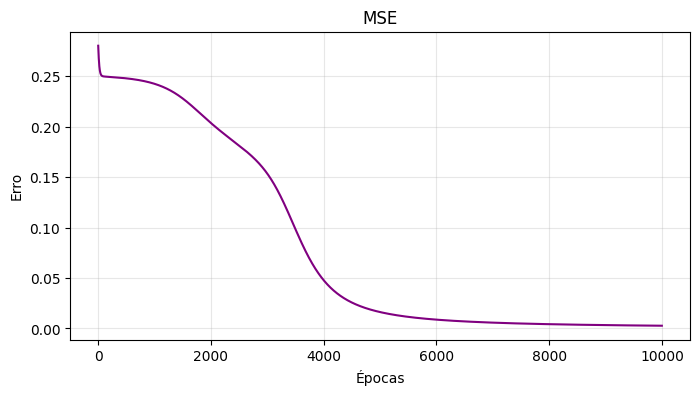

In [30]:
plotar_erro(nn)

In [ ]:
animar_fronteira(nn)